In [20]:
import torch
import torch.nn as nn
import json
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from PIL import Image, ImageDraw
import torchvision.transforms as transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import os

import utils

Подготовка датасета

In [21]:
TRAIN_DATA_DIR = 'data/train_images/train_images'
TEST_DATA_DIR = 'data/test_images/test_images'

In [22]:
with open('data/usdc_train.json', 'r') as file:
    train_data = json.load(file)

In [23]:
classes_dict = {}
for sample in train_data['categories']:
    classes_dict[sample['id']-1] = sample['name']
del classes_dict[-1]
classes_dict 

{0: 'biker',
 1: 'car',
 2: 'pedestrian',
 3: 'trafficLight',
 4: 'trafficLight-Green',
 5: 'trafficLight-GreenLeft',
 6: 'trafficLight-Red',
 7: 'trafficLight-RedLeft',
 8: 'trafficLight-Yellow',
 9: 'trafficLight-YellowLeft',
 10: 'truck'}

In [24]:
classes_colors = ['red', 'blue', 'green', 'violet', 'gold', 'brown',
                  'darkseagreen', 'aquamarine', 'olive', 'plum', 'sandybrown']

In [25]:
annotations_df = pd.DataFrame(train_data['annotations'])
annotations_df = annotations_df.drop(columns=['id', 'segmentation', 'iscrowd', 'confidence', 'score'])
annotations_df.head()

,image_id,category_id,bbox,area
0,5,2,"[196, 234, 20.266666666666666, 24.74666666666667]",501.532444
1,5,2,"[247, 236, 16.53333333333333, 24.74666666666667]",409.144889
2,5,2,"[265, 234, 20.8, 23.893333333333334]",496.981333
3,5,2,"[267, 237, 15.466666666666667, 17.066666666666...",263.964444
4,5,2,"[305, 233, 78.93333333333334, 75.94666666666667]",5994.723556


In [26]:
annotations_df['category_id'].unique()

array([ 2,  8,  1,  7, 11,  3,  4,  5,  9,  6, 10])

In [27]:
annotations_df['category_id'] = annotations_df['category_id'].apply(lambda x: x - 1)

In [28]:
images_df = pd.DataFrame(train_data['images'])
images_df = images_df.drop(columns=['license', 'height', 'width', 'date_captured'])
images_df = images_df.rename(columns={'id' : 'image_id'})
images_df.head()

,image_id,file_name
0,5,1478020898717725646_jpg.rf.68EjFVQdDWrB0SW6qVl...
1,14,1478020650710690845_jpg.rf.68NUjFyrbU9Nsyt3ika...
2,22,1478898975867837103_jpg.rf.6847BekYxQ4SlhtvjlE...
3,57,1478895940606118436_jpg.rf.68xNq7HL27EKmRnrGgp...
4,58,1478896447910420804_jpg.rf.68xeyVz6sbVFpLVku7W...


In [29]:
train_annotations = utils.create_dataset(images_df, annotations_df)

In [93]:
class DetectionDataset(Dataset):
    def __init__(self, annotations: dict, img_dir: str, transform=None):
        self.annotations = annotations
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        sample = self.annotations[idx]
        img_path = os.path.join(TRAIN_DATA_DIR, sample['file_name'])
        
        image = Image.open(img_path)
        
        bboxes = []
        labels = []
        for obj in sample['annotations']:
            bboxes.append(obj['bbox'])
            labels.append(obj['class'])
            
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        w_old, h_old = image.size
        
        if self.transform:
            image = self.transform(image)
            w_new, h_new = image.shape[1], image.shape[2]
            scale_x = w_new / w_old
            scale_y = h_new / h_old
            
            for i, bbox in enumerate(bboxes):
                x_old, y_old, w_old, h_old = bbox
                bboxes[i] = torch.tensor([x_old * scale_x, y_old * scale_y, w_old * scale_x, h_old * scale_y],
                                         dtype=torch.float32)
            
            
        return image, {'bboxes' : bboxes, 'labels' : labels}

In [59]:
train_dataset = DetectionDataset(train_annotations, TRAIN_DATA_DIR)

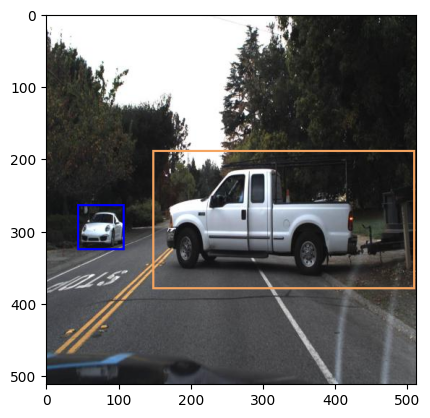

In [89]:
image = train_dataset[2323][0]
bboxes = train_dataset[2323][1]['bboxes']
labels = train_dataset[2323][1]['labels']

utils.plot_image(image, bboxes, labels, classes_colors)

Добавление Local Contrast Normalization и различных трансформаций

# TODO:
1. Добавить корректировку bboxes относительно HorizontalFlip
2. Добавить корректировку bboxes относительно RandomRotation

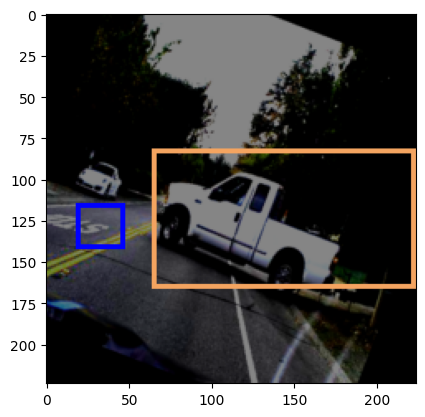

In [94]:
basic_transforms = transforms.Compose(
    [v2.RandomHorizontalFlip(),
    transforms.RandomRotation((-30, 30)),
    v2.ColorJitter(brightness=(0.4, 2), contrast=(1, 6),
            saturation=(0, 2.5), hue=(-0.25,0.25)),
    v2.RandomInvert(0.3),
    transforms.Resize((224, 224)),
    transforms.ToTensor()]
)

# transformed_img = basic_transforms(img)
# transforms.functional.to_pil_image(transformed_img)

train_dataset_bt = DetectionDataset(train_annotations, TRAIN_DATA_DIR, transform=basic_transforms)
image = transforms.functional.to_pil_image(train_dataset_bt[2323][0])
bboxes = train_dataset_bt[2323][1]['bboxes']
labels = train_dataset_bt[2323][1]['labels']
utils.plot_image(image, bboxes, labels, classes_colors)

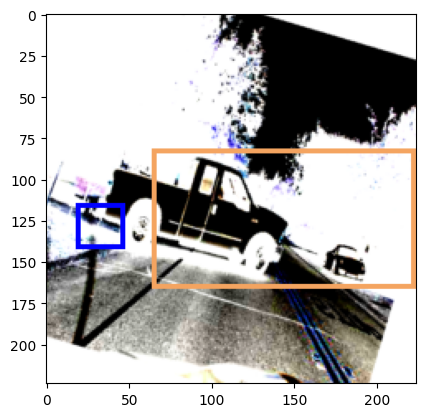

In [95]:
basic_transforms_with_norm = transforms.Compose(
    [v2.RandomHorizontalFlip(),
    transforms.RandomRotation((-30, 30)),
    v2.ColorJitter(brightness=(0.4, 2), contrast=(1, 6),
            saturation=(0, 2.5), hue=(-0.25,0.25)),
    v2.RandomInvert(0.4),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    utils.LocalContrastNorm(kernel_size=7)]
)

# transformed_img = basic_transforms_with_norm(img)
# transforms.functional.to_pil_image(transformed_img)

train_dataset_btn = DetectionDataset(train_annotations, TRAIN_DATA_DIR, transform=basic_transforms)
image = transforms.functional.to_pil_image(train_dataset_btn[2323][0])
bboxes = train_dataset_btn[2323][1]['bboxes']
labels = train_dataset_btn[2323][1]['labels']
utils.plot_image(image, bboxes, labels, classes_colors)